In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from data_import import load_data
from model_dfs import prepare_nig_inputs
#from nig_em_paper import EM_algo, one_year_pd_timeseries
from nig_gibbs import gibbs_sampler

ModuleNotFoundError: No module named 'data_import'

In [ ]:
# Load Accenture dataset
ret_daily, bs = load_data(
    xlsx_path= None,
    verbose=True
)

print(ret_daily.head())
print("-"*40)
print(bs.head())
print("-"*40)

# Load ECB 1Y risk-free yield data

# If first time, call API to get data, otherwise:
path = Path.cwd() / "data/derived" / "ecb_riskfree_1y_daily.csv"
df_rf= pd.read_csv(path, parse_dates=["date"])
print(df_rf.head())

      country_iso          isin       date                       company  \
41651         DEU  DE0005190003 2010-01-05  BAYERISCHE MOTOREN WERKE AKT   
41652         DEU  DE0005190003 2010-01-06  BAYERISCHE MOTOREN WERKE AKT   
41653         DEU  DE0005190003 2010-01-07  BAYERISCHE MOTOREN WERKE AKT   
41654         DEU  DE0005190003 2010-01-08  BAYERISCHE MOTOREN WERKE AKT   
41655         DEU  DE0005190003 2010-01-11  BAYERISCHE MOTOREN WERKE AKT   

        gvkey   shares_out   close  mcap_reported  shares_out_filled  \
41651  100022  601995196.0  32.310   1.945046e+10        601995196.0   
41652  100022  601995196.0  32.810   1.975146e+10        601995196.0   
41653  100022  601995196.0  33.100   1.992604e+10        601995196.0   
41654  100022  601995196.0  32.655   1.965815e+10        601995196.0   
41655  100022  601995196.0  32.170   1.936619e+10        601995196.0   

               mcap  bad_day  logret_close  logret_mcap  
41651  1.945046e+10    False      0.008080     0.008

In [ ]:
# Build NIG inputs and fill missing liabilities
df_nig_panel, nig_em_data = prepare_nig_inputs(ret_daily, bs, df_rf)
print(df_nig_panel.head(50))


     gvkey       date             E          isin  \
0   100022 2010-01-05  1.945046e+10  DE0005190003   
1   100080 2010-01-05  4.578810e+10  DE000BAY0017   
2   100312 2010-01-05  1.765719e+09  DE0007030009   
3   100581 2010-01-05  4.701386e+10  FR0000120321   
4   100957 2010-01-05  3.539016e+10  ES0144580Y14   
5   101202 2010-01-05  2.188290e+10  FR0000120073   
6   101204 2010-01-05  7.372136e+10  FR0000120578   
7   101248 2010-01-05  8.674785e+09  FR0000121667   
8   101305 2010-01-05  6.061525e+09  FR0000073272   
9   101336 2010-01-05  2.149174e+10  FR0000121972   
10  101361 2010-01-05  4.566206e+09  NL0000395903   
11  102296 2010-01-05  2.096499e+10  FR0000125486   
12  103487 2010-01-05  4.002267e+10  DE0007164600   
13  132740 2010-01-05  4.605613e+09  DE0006231004   
14   14140 2010-01-05  9.784074e+10  ES0113900J37   
15   14447 2010-01-05  3.839475e+10  FR0000121014   
16   15181 2010-01-05  4.973802e+10  ES0113211835   
17   15532 2010-01-05  6.765080e+10  FR0000131

In [11]:
# NIG implementation: most recent verions (15-02)
import importlib
import nig_base, nig_em, nig_pd

importlib.reload(nig_base)
importlib.reload(nig_em)
importlib.reload(nig_pd)

df = df_nig_panel.copy()

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["gvkey", "date"])

gv = df["gvkey"].iloc[0]          # pick any firm id
g = df[df["gvkey"] == gv].copy().sort_values("date")

dates = g["date"].to_numpy()
E = g["E"].to_numpy(float)
L = g["L"].to_numpy(float)        # liability proxy used as strike, per case instructions :contentReference[oaicite:2]{index=2}
r = g["r"].to_numpy(float)

start_params = {
    "alpha": 1.0,     # >= 0.51
    "beta1": 0.0,     # |beta|<alpha
    "delta": 0.2,     # >0
    "beta0": 0.0,     # mu
}

daycount = 250
t_end = daycount - 1  # last day of first-year window

nig_em.get_asset_path = nig_base.get_asset_path
nig_em.update_theta   = nig_base.update_theta  # if EM_algo uses update_theta from its own namespace

# now rerun EM
out = nig_em.EM_algo(
    E_series=E,
    L_face_series=L,
    rf_series=r,
    dates=dates,
    start_params=start_params,
    start_date=dates[0],
    end_date=dates[t_end],
    tau_mode="one_year",
    liability_mode="timevarying",
)


In [16]:
importlib.reload(nig_pd)
out.keys()
out["converged"], out["n_iter"], out["diff_last"]
out["params"]
import numpy as np

A_win = np.asarray(out["A_win"], float)
theta_win = np.asarray(out["theta_win"], float)

print("A_win finite share:", np.mean(np.isfinite(A_win) & (A_win > 0)))
print("A_win min/max:", np.nanmin(A_win), np.nanmax(A_win))

print("theta finite share:", np.mean(np.isfinite(theta_win)))
print("theta min/max:", np.nanmin(theta_win), np.nanmax(theta_win))
pd_win = nig_pd.one_year_pd_timeseries(out, L_face_series_full=L)
pd_win.head()
pd_win.tail()



A_win finite share: 1.0
A_win min/max: 102442423960.57495 123713210415.90425
theta finite share: 1.0
theta min/max: -25.8712578995753 -25.09894205357923


,date,A_hat,theta,L_proxy,PD_physical,PD_risk_neutral
245,2010-12-14,1.227527e+11,-25.276234,8.576700e+10,1.121441e-10,0.000020
246,2010-12-15,1.227628e+11,-25.273410,8.576700e+10,1.114626e-10,0.000020
247,2010-12-16,1.229429e+11,-25.263563,8.576700e+10,1.000435e-10,0.000018
248,2010-12-17,1.224341e+11,-25.267967,8.576700e+10,1.357366e-10,0.000022
249,2010-12-20,1.231646e+11,-25.280070,8.576700e+10,8.756523e-11,0.000017


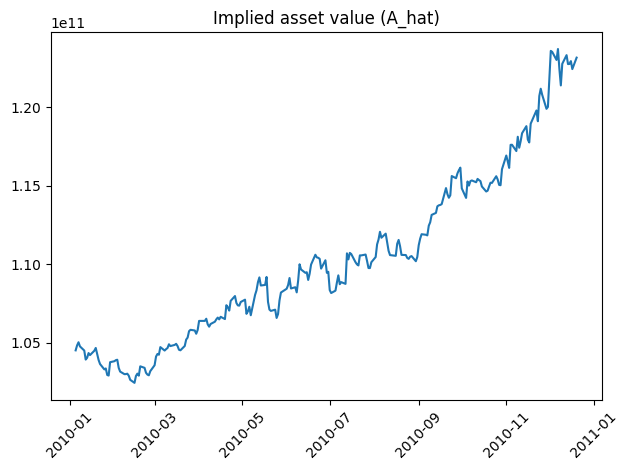

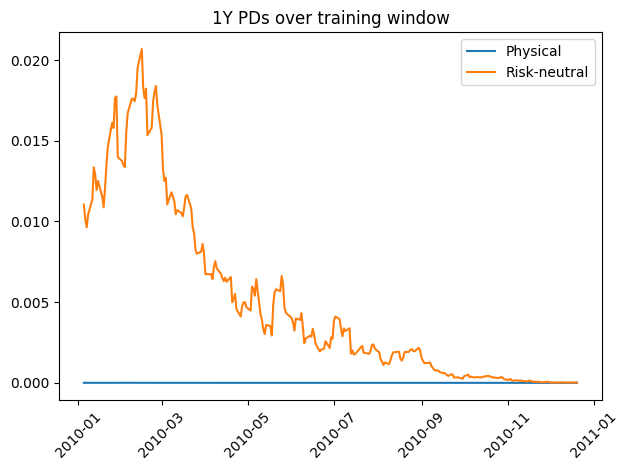

In [17]:
import matplotlib.pyplot as plt

pd_win = pd_win.sort_values("date")

plt.figure()
plt.plot(pd_win["date"], pd_win["A_hat"])
plt.title("Implied asset value (A_hat)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(pd_win["date"], pd_win["PD_physical"], label="Physical")
plt.plot(pd_win["date"], pd_win["PD_risk_neutral"], label="Risk-neutral")
plt.title("1Y PDs over training window")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
last = pd_win.iloc[-1]
print(
    f"converged={out['converged']} | n_iter={out['n_iter']} | "
    f"alpha={out['params']['alpha']:.3f}, beta1={out['params']['beta1']:.3f}, "
    f"delta={out['params']['delta']:.3f}, mu={out['params']['beta0']:.3f} | "
    f"PDp={last['PD_physical']:.4%}, PDq={last['PD_risk_neutral']:.4%}"
)


converged=False | n_iter=10 | alpha=233.738, beta1=45.553, delta=1.806, mu=-0.154 | PDp=0.0000%, PDq=0.0017%


In [1]:
pd_win = nig_pd.one_year_pd_timeseries(out, L_face_series_full=L)
pd_win.tail()

NameError: name 'nig_pd' is not defined

In [13]:
def run_daily_pd_series_full_recalibration(g: pd.DataFrame, daycount=250, max_window=500):
    g = g.sort_values("date")
    dates = g["date"].to_numpy()
    E = g["E"].to_numpy(float)
    L = g["L"].to_numpy(float)
    r = g["r"].to_numpy(float)

    start_params = {"alpha": 1.0, "beta1": 0.0, "delta": 0.2, "beta0": 0.0}
    rows = []

    for t_end in range(daycount - 1, len(dates)):
        # expanding then rolling
        if t_end < max_window - 1:
            t_start = 0
        else:
            t_start = t_end - (max_window - 1)

        out = nig_em.EM_algo(
            E_series=E,
            L_face_series=L,
            rf_series=r,
            dates=dates,
            start_params=start_params,
            start_date=dates[t_start],
            end_date=dates[t_end],
        )

        # compute PDs on the window, keep only the last row
        pd_win = nig_pd.one_year_pd_timeseries(out, L_face_series_full=L)
        last = pd_win.iloc[-1]

        rows.append({
            "date": last["date"],
            "PD_physical": last["PD_physical"],
            "PD_risk_neutral": last["PD_risk_neutral"],
            "alpha": out["params"]["alpha"],
            "beta1": out["params"]["beta1"],
            "delta": out["params"]["delta"],
            "beta0": out["params"]["beta0"],
        })

        # warm start next run (important for speed/stability; EM is sensitive to initial values) :contentReference[oaicite:7]{index=7}
        start_params = out["params"]

    return pd.DataFrame(rows)

pd_series = run_daily_pd_series_full_recalibration(g)
pd_series.head(), pd_series.tail()


KeyboardInterrupt: 

In [ ]:
# nig_em_paper loop
df_nig_panel = df_nig_panel.sort_values(["gvkey", "date"]).reset_index(drop=True)
print(df_nig_panel.head())

start_date = np.datetime64("2015-01-01")
end_date   = np.datetime64("2015-12-31")

# EM start params (your defaults)
start_params = {"alpha": 1.0, "beta1": 0.0, "delta": 1.0, "beta0": 0.0}

# how many firms to run (EM + PD) right now
n_firms = 5  # <-- change this

errors = []
em_results = []
pd_panels = []

done = 0

for gvkey, g in df_nig_panel.groupby("gvkey", sort=False):
    if done >= n_firms:
        break

    company = g["company"].iloc[0]

    try:
        # ensure numpy datetime64[ns]
        dates_np = g["date"].to_numpy()
        if not np.issubdtype(dates_np.dtype, np.datetime64):
            dates_np = pd.to_datetime(dates_np).to_numpy(dtype="datetime64[ns]")
        else:
            dates_np = pd.to_datetime(dates_np).to_numpy(dtype="datetime64[ns]")

        # --- EM ---
        em_out = EM_algo(
            E_series=g["E"].to_numpy(dtype=float),
            L_face_series=g["L"].to_numpy(dtype=float),
            rf_series=g["r"].to_numpy(dtype=float),
            dates=dates_np,
            start_params=start_params,
            start_date=start_date,
            end_date=end_date,
            max_iter=10,
            min_iter=3,
            tol=1e-3,
        )

        em_params = em_out["params"]

        print(
            f"{company} | EM_converged={em_out['converged']} (n_iter={em_out['n_iter']}) | "
            f"alpha={em_params['alpha']:.6f} | beta1={em_params['beta1']:.6f} | "
            f"delta={em_params['delta']:.6f} | beta0={em_params['beta0']:.6f}"
        )

        # store EM params
        em_results.append({
            "gvkey": gvkey,
            "company": company,
            "converged": bool(em_out["converged"]),
            "n_iter": int(em_out["n_iter"]),
            "alpha": float(em_params["alpha"]),
            "beta1": float(em_params["beta1"]),
            "delta": float(em_params["delta"]),
            "beta0": float(em_params["beta0"]),
        })

        # --- PD time series on training window ---
        pd_df = one_year_pd_timeseries(em_out, L_face_series_full=g["L"].to_numpy(dtype=float))
        pd_df["date"] = pd.to_datetime(pd_df["date"])
        pd_df["gvkey"] = gvkey
        pd_df["company"] = company
        pd_panels.append(pd_df)

        tail = pd_df[["date", "PD_physical", "PD_risk_neutral"]].tail(5)
        for _, row in tail.iterrows():
            date_str = row["date"].strftime("%Y-%m-%d")
            print(
                f"  {date_str} | PD_P(%)={row['PD_physical']*100:.6f} | "
                f"PD_Q(%)={row['PD_risk_neutral']*100:.6f}"
            )

        done += 1  # <-- count only successful runs

    except Exception as e:
        print(f"{company} | ERROR: {e}")
        errors.append({"gvkey": gvkey, "company": company, "error": str(e)})
        # (optional) still count failures toward n_firms:
        # done += 1

errors_df = pd.DataFrame(errors)
print("\nErrors:", len(errors_df))

em_results_df = pd.DataFrame(em_results)
em_params_by_gvkey = (
    em_results_df
    .set_index("gvkey")[["alpha", "beta1", "delta", "beta0"]]
    .to_dict(orient="index")
)

pd_panel_df = pd.concat(pd_panels, ignore_index=True) if len(pd_panels) else pd.DataFrame()


KeyboardInterrupt: 

In [9]:
em_params_by_gvkey = (
    em_results_df
    .dropna(subset=["alpha","beta1","delta","beta0"])
    .set_index("gvkey")[["alpha","beta1","delta","beta0"]]
    .to_dict(orient="index")
)

n_firms = 5
start_date = np.datetime64("2015-01-01")
end_date   = np.datetime64("2015-12-31")

rng = np.random.default_rng(12345)

gibbs_results = []
errors = []

for j, (gvkey, g) in enumerate(df_nig_panel.groupby("gvkey", sort=False), start=1):
    if j > n_firms:
        break

    company = g["company"].iloc[0]

    try:
        # pull EM params (skip firm if missing)
        if gvkey not in em_params_by_gvkey:
            raise ValueError("No EM params stored for this gvkey (run EM first or fix results_df).")

        em_params = em_params_by_gvkey[gvkey]  # {'alpha':..., 'beta1':..., 'delta':..., 'beta0':...}

        dates_arr = pd.to_datetime(g["date"]).to_numpy(dtype="datetime64[ns]")
        E_arr  = g["E"].to_numpy(dtype=float)
        L_arr  = g["L"].to_numpy(dtype=float)
        rf_arr = g["r"].to_numpy(dtype=float)

        gibbs_out = gibbs_sampler(
            E_series=E_arr,
            L_series=L_arr,
            rf_series=rf_arr,
            dates=dates_arr,
            start_date=start_date,
            end_date=end_date,
            max_iter=100,
            burn_in=20,
            thin=2,
            trading_days=250,
            em_params=em_params,     # <-- used to center priors/hyperparams inside gibbs_sampler
            rng=rng,
        )

        meta = gibbs_out["meta"]
        print(f"{company} | Gibbs kept={meta['n_keep_actual']} | reject={meta['n_reject']}")

        # ---- print last 5 kept (thinned) parameter draws ----
        draws = np.asarray(gibbs_out["params_draws"], dtype=float)  # columns: [alpha, beta1, delta, beta0]
        if draws.shape[0] == 0:
            print("  (no kept draws)")
        else:
            last5 = draws[-5:, :]  # if fewer than 5, this just returns all
            for k_i, (a, b1, d, b0) in enumerate(last5, start=max(1, draws.shape[0]-last5.shape[0]+1)):
                print(
                    f"  draw {k_i:>4d} | alpha={a:.6f} | beta1={b1:.6f} | delta={d:.6f} | beta0={b0:.6f}"
                )


        gibbs_results.append({"gvkey": gvkey, "company": company, "gibbs": gibbs_out})

    except Exception as e:
        print(f"{company} | ERROR: {e}")
        errors.append({"gvkey": gvkey, "company": company, "error": str(e)})

errors_df = pd.DataFrame(errors)

BAYERISCHE MOTOREN WERKE AKT | Gibbs kept=40 | reject=0
  draw   36 | alpha=281.228970 | beta1=0.640942 | delta=2.909185 | beta0=0.035513
  draw   37 | alpha=274.069835 | beta1=-3.599190 | delta=2.908148 | beta0=0.172146
  draw   38 | alpha=220.893710 | beta1=11.636202 | delta=2.387276 | beta0=0.109794
  draw   39 | alpha=242.755335 | beta1=3.069099 | delta=2.382807 | beta0=0.123524
  draw   40 | alpha=242.335257 | beta1=1.271418 | delta=2.332377 | beta0=-0.004897


KeyboardInterrupt: 

In [ ]:
# Approach 2
from nig_gibbs import gibbs_sampler
import numpy as np

em_params = em_init.params.copy()
em_params["theta"] = float(em_init.theta_series[-1])  # starting theta for pricing

draws = gibbs_sampler(
    equity=E, liabilities_L=float(L), r_series=r,
    maturity_T=1.0,                 # PD horizon used inside sampler
    n_iter=5000, burn_in=1000,
    em_params=em_params,
    thin=20,
    physical_measure=True,
)

pd_mean = float(np.mean(draws["pd"]))
pd_p05, pd_p95 = np.quantile(draws["pd"], [0.05, 0.95])
print("Posterior mean PD:", pd_mean, "90% CI:", (pd_p05, pd_p95))
